# Demo: Statistical Analyses and Figure Generation

This notebook reproduces the manuscript figures and demonstrates the statistical analyses.

## Analyses and Figures

| Figure | Description |
|--------|-------------|
| **Fig 6** | Model and Dataset Size Predict Relational Abstraction |
| **Fig 7** | Limited Information Capacity Predicts Concrete Strategies |
| **Fig 8** | Capacity Effects Within Fixed Architectures |
| **Fig 9** | Random Forest Feature Importance and SHAP |
| **Fig 10** | GAM Analysis (Deviance Reduction and Partial Dependence) |
| **Fig 11** | Language Supervision Effects (VLM vs Vision-Only) |
| **Fig 12** | Simulated Partial Dependence Plots |

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
import seaborn as sns
from scipy import stats
from scipy.special import expit
from scipy.ndimage import gaussian_filter1d
import statsmodels.api as sm
from statsmodels.formula.api import logit
from pygam import LinearGAM, s, f, te
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score
import shap
from pathlib import Path
import os
import warnings
warnings.filterwarnings('ignore')

# Set default plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Load data
data_file = Path('data/aggregated_metrics/all_metrics_deduplicated.csv')
if data_file.exists():
    df = pd.read_csv(data_file)
    print(f'Loaded {len(df)} models with {len(df.columns)} features')
else:
    print(f'Data file not found: {data_file}')
    print('Make sure you are running from submission_package/ directory')

# Create output directory for figures
fig_dir = Path('figures')
fig_dir.mkdir(exist_ok=True)
print(f'Figures will be saved to: {fig_dir}/')

print('\nSetup complete!')

Loaded 1204 models with 52 features
Figures will be saved to: figures/

Setup complete!


## 1. Data Overview

### 1.1 Key Metrics

In [2]:
# Define key metrics
metrics = {
    'sem_dist_effect': 'Semantic Distance Effect',
    'diff_symbolic_r': 'Regularity Effect',
    'relational_bias': 'Relational Bias'
}

print('='*70)
print('SUMMARY STATISTICS FOR KEY METRICS')
print('='*70)

for col, name in metrics.items():
    if col in df.columns:
        values = df[col].dropna()
        print(f'\n{name}:')
        print(f'  N = {len(values)}')
        print(f'  Mean = {values.mean():.4f}')
        print(f'  Std = {values.std():.4f}')
        print(f'  Range = [{values.min():.4f}, {values.max():.4f}]')

SUMMARY STATISTICS FOR KEY METRICS

Semantic Distance Effect:
  N = 1204
  Mean = 0.3820
  Std = 0.1715
  Range = [-0.3608, 0.7921]

Regularity Effect:
  N = 1204
  Mean = 0.4575
  Std = 0.1480
  Range = [-0.1698, 0.7672]

Relational Bias:
  N = 1204
  Mean = 0.3297
  Std = 0.1602
  Range = [0.0238, 0.8889]


### 1.2 Distribution Plots

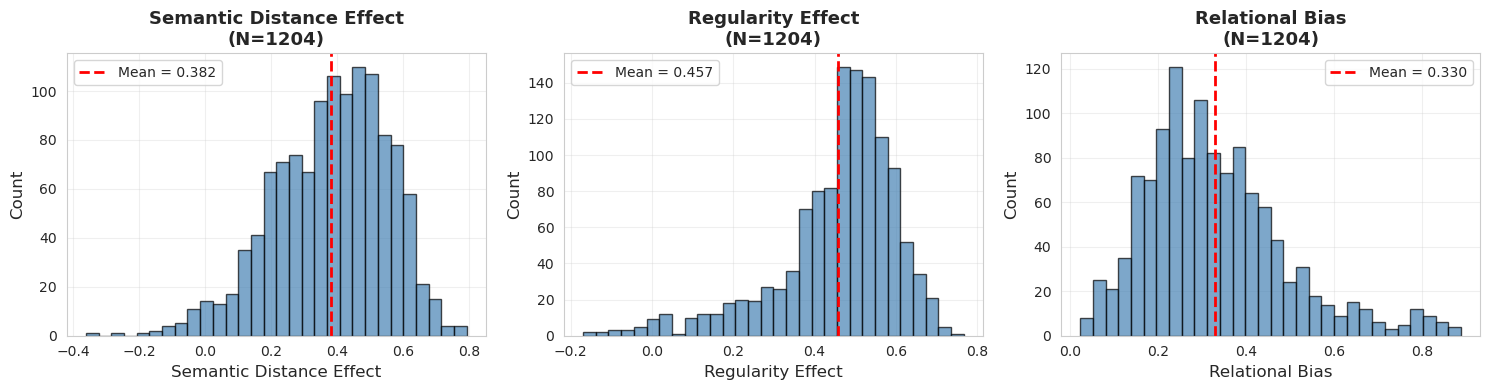

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, (col, name) in enumerate(metrics.items()):
    if col in df.columns:
        values = df[col].dropna()
        axes[i].hist(values, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
        axes[i].axvline(values.mean(), color='red', linestyle='--', 
                       linewidth=2, label=f'Mean = {values.mean():.3f}')
        axes[i].set_xlabel(name, fontsize=12)
        axes[i].set_ylabel('Count', fontsize=12)
        axes[i].set_title(f'{name}\n(N={len(values)})', fontsize=13, fontweight='bold')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## 2. Manuscript Figures

### Figure 6: Model and Dataset Size Predict Relational Abstraction

A 2x3 panel figure showing:
- **A**: Model size quartiles vs % relational bias
- **B**: Dataset size categories vs % relational bias
- **C**: Joint distribution heatmap
- **D**: Logistic regression odds ratios
- **E-F**: Predicted probability curves

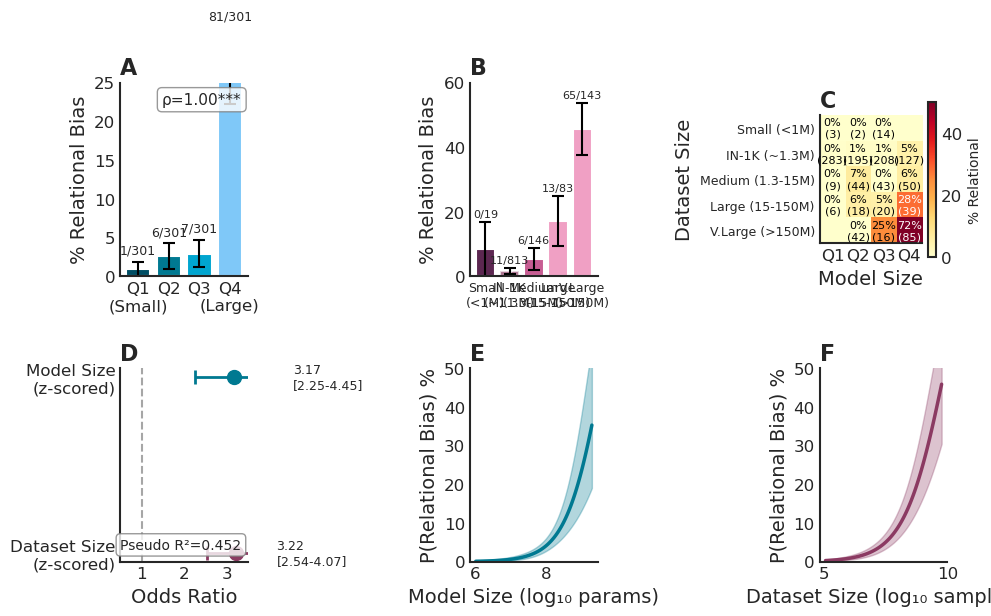

Model Size OR: 3.17, Dataset Size OR: 3.22, Pseudo R2: 0.452
Saved: figures/figure_6.png


In [4]:
# Figure 6: Relational Bias

plt.style.use('seaborn-v0_8-white')
plt.rcParams.update({
    'font.size': 14, 'axes.titlesize': 16, 'axes.labelsize': 14,
    'xtick.labelsize': 12, 'ytick.labelsize': 12, 'figure.titlesize': 18,
    'font.family': 'DejaVu Sans', 'axes.linewidth': 1.5,
    'axes.spines.top': False, 'axes.spines.right': False,
})

def wilson_ci(successes, total, confidence=0.95):
    if total == 0:
        return 0, 0, 0
    p = successes / total
    z = stats.norm.ppf(1 - (1 - confidence) / 2)
    denominator = 1 + z**2 / total
    center = (p + z**2 / (2 * total)) / denominator
    margin = z * np.sqrt((p * (1 - p) + z**2 / (4 * total)) / total) / denominator
    return center * 100, max(0, (center - margin) * 100), min(100, (center + margin) * 100)

fig, axes = plt.subplots(2, 3, figsize=(10, 6.5))
model_colors = ['#004E64', '#007991', '#00A5CF', '#7FC8F8']
data_colors = ['#5C2751', '#8B3A62', '#C75D93', '#F0A0C4']

df_model = df.dropna(subset=['model_params_log10']).copy()
df_model['size_quartile'] = pd.qcut(df_model['model_params_log10'].rank(method='first'), q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

def categorize_dataset(log_size):
    if pd.isna(log_size): return None
    size = 10 ** log_size
    if size < 1_000_000: return 'Small\n(<1M)'
    elif size <= 1_500_000: return 'IN-1K\n(~1.3M)'
    elif size <= 15_000_000: return 'Medium\n(1.3-15M)'
    elif size <= 150_000_000: return 'Large\n(15-150M)'
    else: return 'V.Large\n(>150M)'

df['dataset_category'] = df['dataset_size_log10'].apply(categorize_dataset)
cat_order = ['Small\n(<1M)', 'IN-1K\n(~1.3M)', 'Medium\n(1.3-15M)', 'Large\n(15-150M)', 'V.Large\n(>150M)']

# Panel A: Model Size Binned
ax = axes[0, 0]
quartile_labels = ['Q1', 'Q2', 'Q3', 'Q4']
percentages, lowers, uppers = [], [], []
for q in quartile_labels:
    subset = df_model[df_model['size_quartile'] == q]
    pct, lo, hi = wilson_ci(subset['relational_bias_binary'].sum(), len(subset))
    percentages.append(pct); lowers.append(pct - lo); uppers.append(hi - pct)
bars = ax.bar(range(4), percentages, color=model_colors, edgecolor='white', linewidth=1.5)
ax.errorbar(range(4), percentages, yerr=[lowers, uppers], fmt='none', color='black', capsize=4, capthick=1.5)
for i, q in enumerate(quartile_labels):
    subset = df_model[df_model['size_quartile'] == q]
    ax.text(i, percentages[i] + uppers[i] + 1, f'{int(subset["relational_bias_binary"].sum())}/{len(subset)}', ha='center', fontsize=9)
ax.set_xticks(range(4)); ax.set_xticklabels(['Q1\n(Small)', 'Q2', 'Q3', 'Q4\n(Large)'])
ax.set_ylabel('% Relational Bias'); ax.set_title('A', fontweight='bold', loc='left', fontsize=16); ax.set_ylim(0, 25)
r, p = stats.spearmanr([1,2,3,4], percentages)
sig = '***' if p < 0.001 else ('**' if p < 0.01 else ('*' if p < 0.05 else ''))
ax.text(0.95, 0.95, f'\u03c1={r:.2f}{sig}', transform=ax.transAxes, ha='right', va='top', fontsize=11,
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='gray'))

# Panel B: Dataset Size Categories
ax = axes[0, 1]
percentages, lowers, uppers = [], [], []
for cat in cat_order:
    subset = df[df['dataset_category'] == cat]
    if len(subset) > 0:
        pct, lo, hi = wilson_ci(subset['relational_bias_binary'].sum(), len(subset))
    else:
        pct, lo, hi = 0, 0, 0
    percentages.append(pct); lowers.append(pct - lo); uppers.append(hi - pct)
bars = ax.bar(range(5), percentages, color=data_colors + [data_colors[-1]], edgecolor='white', linewidth=1.5)
ax.errorbar(range(5), percentages, yerr=[lowers, uppers], fmt='none', color='black', capsize=4, capthick=1.5)
bars[1].set_hatch('//'); bars[1].set_alpha(0.7)
for i, cat in enumerate(cat_order):
    subset = df[df['dataset_category'] == cat]
    if len(subset) > 0:
        ax.text(i, percentages[i] + uppers[i] + 1.5, f'{int(subset["relational_bias_binary"].sum())}/{len(subset)}', ha='center', fontsize=8)
ax.set_xticks(range(5)); ax.set_xticklabels(cat_order, fontsize=9)
ax.set_ylabel('% Relational Bias'); ax.set_title('B', fontweight='bold', loc='left', fontsize=16); ax.set_ylim(0, 60)

# Panel C: 2D Heatmap
ax = axes[0, 2]
df_both = df.dropna(subset=['model_params_log10', 'dataset_size_log10']).copy()
df_both['model_bin'] = pd.qcut(df_both['model_params_log10'].rank(method='first'), q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
heatmap_data = np.zeros((5, 4)); counts_data = np.zeros((5, 4))
for i, dcat in enumerate(cat_order):
    for j, mq in enumerate(['Q1', 'Q2', 'Q3', 'Q4']):
        subset = df_both[(df_both['dataset_category'] == dcat) & (df_both['model_bin'] == mq)]
        if len(subset) > 0:
            heatmap_data[i, j] = subset['relational_bias_binary'].mean() * 100
            counts_data[i, j] = len(subset)
im = ax.imshow(heatmap_data, cmap='YlOrRd', aspect='equal', vmin=0, vmax=50)
for i in range(5):
    for j in range(4):
        if counts_data[i, j] > 0:
            text_color = 'white' if heatmap_data[i, j] > 25 else 'black'
            ax.text(j, i, f'{heatmap_data[i, j]:.0f}%\n({int(counts_data[i, j])})', ha='center', va='center', fontsize=8, color=text_color)
ax.set_xticks(range(4)); ax.set_xticklabels(['Q1', 'Q2', 'Q3', 'Q4'])
ax.set_yticks(range(5)); ax.set_yticklabels([c.replace('\n', ' ') for c in cat_order], fontsize=9)
ax.set_xlabel('Model Size'); ax.set_ylabel('Dataset Size'); ax.set_title('C', fontweight='bold', loc='left', fontsize=16)
cbar = plt.colorbar(im, ax=ax, shrink=0.8); cbar.set_label('% Relational', fontsize=10)

# Panel D: Logistic Regression Odds Ratios
ax = axes[1, 0]
df_reg = df.dropna(subset=['model_params_log10', 'dataset_size_log10', 'relational_bias_binary']).copy()
df_reg['model_z'] = (df_reg['model_params_log10'] - df_reg['model_params_log10'].mean()) / df_reg['model_params_log10'].std()
df_reg['data_z'] = (df_reg['dataset_size_log10'] - df_reg['dataset_size_log10'].mean()) / df_reg['dataset_size_log10'].std()
X_logit = sm.add_constant(df_reg[['model_z', 'data_z']])
y_logit = df_reg['relational_bias_binary'].astype(int)
model_rel = sm.Logit(y_logit, X_logit).fit(disp=0)
or_model = np.exp(model_rel.params['model_z']); or_data = np.exp(model_rel.params['data_z'])
ci_model = np.exp(model_rel.conf_int().loc['model_z']); ci_data = np.exp(model_rel.conf_int().loc['data_z'])
pred_labels = ['Model Size\n(z-scored)', 'Dataset Size\n(z-scored)']
ors = [or_model, or_data]; ci_lows = [ci_model[0], ci_data[0]]; ci_highs = [ci_model[1], ci_data[1]]
colors_or = [model_colors[1], data_colors[1]]; y_pos = [1, 0]
for i, (pred, or_val, lo, hi, col) in enumerate(zip(pred_labels, ors, ci_lows, ci_highs, colors_or)):
    ax.errorbar(or_val, y_pos[i], xerr=[[or_val - lo], [hi - or_val]], fmt='o', color=col, markersize=10, capsize=5, capthick=2, linewidth=2)
    ax.text(hi + 0.1, y_pos[i], f'{or_val:.2f}\n[{lo:.2f}-{hi:.2f}]', va='center', fontsize=9)
ax.axvline(x=1, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
ax.set_yticks(y_pos); ax.set_yticklabels(pred_labels)
ax.set_xlabel('Odds Ratio'); ax.set_title('D', fontweight='bold', loc='left', fontsize=16); ax.set_xlim(0.5, 3.5)
pseudo_r2 = 1 - model_rel.llf / model_rel.llnull
ax.text(0.95, 0.05, f'Pseudo R\u00b2={pseudo_r2:.3f}', transform=ax.transAxes, ha='right', va='bottom', fontsize=10,
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='gray'))

# Panel E: Predicted Probability by Model Size
ax = axes[1, 1]
model_range = np.linspace(df_reg['model_z'].min(), df_reg['model_z'].max(), 100)
X_pred = pd.DataFrame({'const': 1, 'model_z': model_range, 'data_z': 0})
pred_probs = model_rel.predict(X_pred)
cov = model_rel.cov_params()
linear_pred = model_rel.params['const'] + model_rel.params['model_z'] * model_range
se_linear = np.sqrt(cov.loc['const', 'const'] + model_range**2 * cov.loc['model_z', 'model_z'] + 2 * model_range * cov.loc['const', 'model_z'])
ci_low = 1 / (1 + np.exp(-(linear_pred - 1.96 * se_linear)))
ci_high = 1 / (1 + np.exp(-(linear_pred + 1.96 * se_linear)))
model_orig = model_range * df_reg['model_params_log10'].std() + df_reg['model_params_log10'].mean()
ax.fill_between(model_orig, ci_low * 100, ci_high * 100, alpha=0.3, color=model_colors[1])
ax.plot(model_orig, pred_probs * 100, color=model_colors[1], linewidth=2.5)
ax.set_xlabel('Model Size (log\u2081\u2080 params)'); ax.set_ylabel('P(Relational Bias) %')
ax.set_title('E', fontweight='bold', loc='left', fontsize=16); ax.set_ylim(0, 50)

# Panel F: Predicted Probability by Dataset Size
ax = axes[1, 2]
data_range = np.linspace(df_reg['data_z'].min(), df_reg['data_z'].max(), 100)
X_pred = pd.DataFrame({'const': 1, 'model_z': 0, 'data_z': data_range})
pred_probs = model_rel.predict(X_pred)
linear_pred = model_rel.params['const'] + model_rel.params['data_z'] * data_range
se_linear = np.sqrt(cov.loc['const', 'const'] + data_range**2 * cov.loc['data_z', 'data_z'] + 2 * data_range * cov.loc['const', 'data_z'])
ci_low = 1 / (1 + np.exp(-(linear_pred - 1.96 * se_linear)))
ci_high = 1 / (1 + np.exp(-(linear_pred + 1.96 * se_linear)))
data_orig = data_range * df_reg['dataset_size_log10'].std() + df_reg['dataset_size_log10'].mean()
ax.fill_between(data_orig, ci_low * 100, ci_high * 100, alpha=0.3, color=data_colors[1])
ax.plot(data_orig, pred_probs * 100, color=data_colors[1], linewidth=2.5)
ax.set_xlabel('Dataset Size (log\u2081\u2080 samples)'); ax.set_ylabel('P(Relational Bias) %')
ax.set_title('F', fontweight='bold', loc='left', fontsize=16); ax.set_ylim(0, 50)

plt.tight_layout()
plt.savefig('figures/figure_6.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print(f'Model Size OR: {or_model:.2f}, Dataset Size OR: {or_data:.2f}, Pseudo R2: {pseudo_r2:.3f}')
print('Saved: figures/figure_6.png')

### Figure 7: Limited Information Capacity Predicts Concrete Strategies

A 2x3 panel figure (Nature style) showing concrete bias analysis:
- **a-b**: Model/dataset size quartiles vs % concrete bias
- **c**: 5x5 joint distribution heatmap
- **d**: Logistic regression odds ratios
- **e-f**: Predicted probability curves

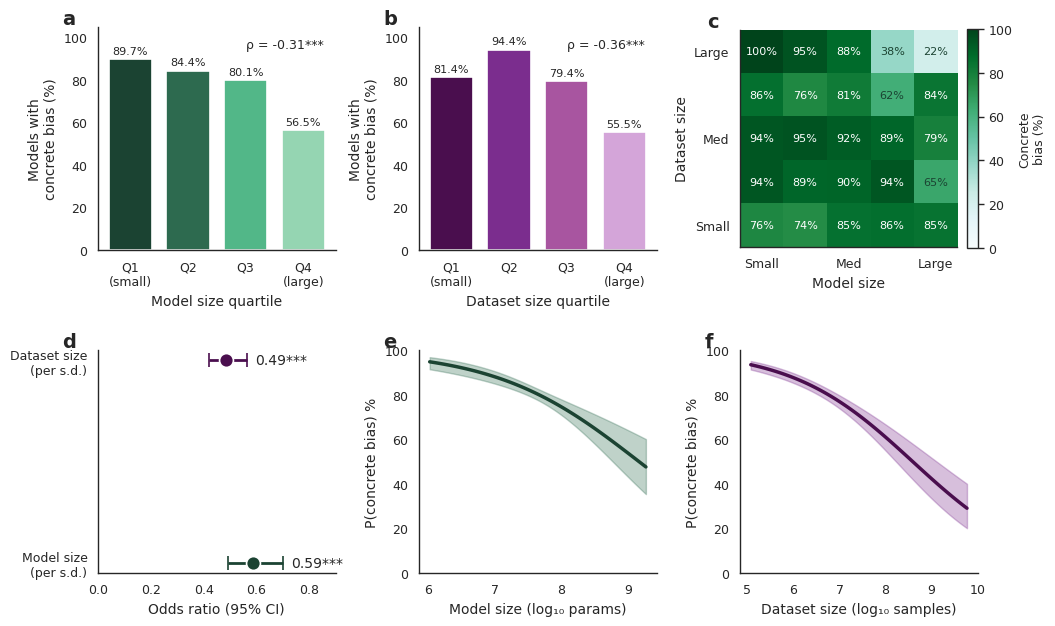

Model Size OR: 0.59, Dataset Size OR: 0.49, Pseudo R2: 0.181
Saved: figures/figure_7.png


In [5]:
# Figure 7: Concrete Bias (Nature style)

plt.rcParams.update({
    'font.size': 10, 'axes.titlesize': 11, 'axes.labelsize': 10,
    'xtick.labelsize': 9, 'ytick.labelsize': 9, 'legend.fontsize': 9,
    'font.family': 'DejaVu Sans', 'axes.linewidth': 1,
    'xtick.major.width': 1, 'ytick.major.width': 1,
    'xtick.major.size': 4, 'ytick.major.size': 4, 'lines.linewidth': 2,
})

con_threshold = 53/126
df['has_concrete_bias'] = (df['relational_bias'] <= con_threshold).astype(int)
df_clean7 = df.dropna(subset=['relational_bias', 'model_params_log10', 'dataset_size_log10']).copy()
df_clean7['model_size_z'] = (df_clean7['model_params_log10'] - df_clean7['model_params_log10'].mean()) / df_clean7['model_params_log10'].std()
df_clean7['data_size_z'] = (df_clean7['dataset_size_log10'] - df_clean7['dataset_size_log10'].mean()) / df_clean7['dataset_size_log10'].std()

model7 = logit('has_concrete_bias ~ model_size_z + data_size_z', data=df_clean7).fit(disp=0)

fig = plt.figure(figsize=(10, 6.5))
gs = GridSpec(2, 3, figure=fig, height_ratios=[1, 1], width_ratios=[1, 1, 1],
              hspace=0.45, wspace=0.35, left=0.07, right=0.95, top=0.94, bottom=0.10)

# Panel A: Model Size Quartiles
ax_a = fig.add_subplot(gs[0, 0])
df_clean7['model_size_quartile'] = pd.qcut(df_clean7['model_params_log10'].rank(method='first'), q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
binned = df_clean7.groupby('model_size_quartile').agg(n_total=('has_concrete_bias', 'count'), n_concrete=('has_concrete_bias', 'sum')).reset_index()
binned['pct'] = binned['n_concrete'] / binned['n_total'] * 100
m_colors = ['#1B4332', '#2D6A4F', '#52B788', '#95D5B2']
bars = ax_a.bar(range(4), binned['pct'], color=m_colors, edgecolor='white', linewidth=1.2, width=0.75)
ax_a.set_xticks(range(4)); ax_a.set_xticklabels(['Q1\n(small)', 'Q2', 'Q3', 'Q4\n(large)'])
ax_a.set_xlabel('Model size quartile'); ax_a.set_ylabel('Models with\nconcrete bias (%)')
ax_a.set_ylim(0, 105)
for bar, pct in zip(bars, binned['pct']):
    ax_a.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1.5, f'{pct:.1f}%', ha='center', va='bottom', fontsize=8)
r, p = stats.spearmanr(df_clean7['model_params_log10'], df_clean7['has_concrete_bias'])
sig = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else ''
ax_a.text(0.95, 0.95, f'\u03c1 = {r:.2f}{sig}', transform=ax_a.transAxes, fontsize=9, va='top', ha='right')
ax_a.spines['top'].set_visible(False); ax_a.spines['right'].set_visible(False)
ax_a.text(-0.15, 1.08, 'a', transform=ax_a.transAxes, fontsize=14, fontweight='bold', va='top')

# Panel B: Dataset Size Quartiles
ax_b = fig.add_subplot(gs[0, 1])
df_clean7['data_size_quartile'] = pd.qcut(df_clean7['dataset_size_log10'].rank(method='first'), q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
binned_d = df_clean7.groupby('data_size_quartile').agg(n_total=('has_concrete_bias', 'count'), n_concrete=('has_concrete_bias', 'sum')).reset_index()
binned_d['pct'] = binned_d['n_concrete'] / binned_d['n_total'] * 100
d_colors = ['#4A0E4E', '#7B2D8E', '#A855A0', '#D4A5D9']
bars = ax_b.bar(range(4), binned_d['pct'], color=d_colors, edgecolor='white', linewidth=1.2, width=0.75)
ax_b.set_xticks(range(4)); ax_b.set_xticklabels(['Q1\n(small)', 'Q2', 'Q3', 'Q4\n(large)'])
ax_b.set_xlabel('Dataset size quartile'); ax_b.set_ylabel('Models with\nconcrete bias (%)')
ax_b.set_ylim(0, 105)
for bar, pct in zip(bars, binned_d['pct']):
    ax_b.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1.5, f'{pct:.1f}%', ha='center', va='bottom', fontsize=8)
r, p = stats.spearmanr(df_clean7['dataset_size_log10'], df_clean7['has_concrete_bias'])
sig = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else ''
ax_b.text(0.95, 0.95, f'\u03c1 = {r:.2f}{sig}', transform=ax_b.transAxes, fontsize=9, va='top', ha='right')
ax_b.spines['top'].set_visible(False); ax_b.spines['right'].set_visible(False)
ax_b.text(-0.15, 1.08, 'b', transform=ax_b.transAxes, fontsize=14, fontweight='bold', va='top')

# Panel C: 2D Heatmap
ax_c = fig.add_subplot(gs[0, 2])
df_clean7['model_bin'] = pd.qcut(df_clean7['model_params_log10'].rank(method='first'), q=5, labels=range(5))
df_clean7['data_bin'] = pd.qcut(df_clean7['dataset_size_log10'].rank(method='first'), q=5, labels=range(5))
hm = df_clean7.groupby(['data_bin', 'model_bin']).agg(n_total=('has_concrete_bias', 'count'), n_concrete=('has_concrete_bias', 'sum')).reset_index()
hm['pct'] = hm['n_concrete'] / hm['n_total'] * 100
matrix = np.full((5, 5), np.nan)
for _, row in hm.iterrows():
    matrix[int(row['data_bin']), int(row['model_bin'])] = row['pct']
im = ax_c.imshow(matrix, cmap='BuGn', aspect='equal', origin='lower', vmin=0, vmax=100)
for i in range(5):
    for j in range(5):
        if not np.isnan(matrix[i, j]):
            color = 'white' if matrix[i, j] > 70 else '#1B4332'
            ax_c.text(j, i, f'{matrix[i, j]:.0f}%', ha='center', va='center', color=color, fontsize=8)
ax_c.set_xticks([0, 2, 4]); ax_c.set_xticklabels(['Small', 'Med', 'Large'])
ax_c.set_yticks([0, 2, 4]); ax_c.set_yticklabels(['Small', 'Med', 'Large'])
ax_c.set_xlabel('Model size'); ax_c.set_ylabel('Dataset size')
cbar = plt.colorbar(im, ax=ax_c, fraction=0.046, pad=0.04); cbar.set_label('Concrete\nbias (%)', fontsize=9)
ax_c.text(-0.15, 1.08, 'c', transform=ax_c.transAxes, fontsize=14, fontweight='bold', va='top')

# Panel D: Odds Ratios
ax_d = fig.add_subplot(gs[1, 0])
params_to_plot = ['model_size_z', 'data_size_z']
labels_d = ['Model size\n(per s.d.)', 'Dataset size\n(per s.d.)']
odds = [np.exp(model7.params[p]) for p in params_to_plot]
ci_lo = [np.exp(model7.conf_int().loc[p, 0]) for p in params_to_plot]
ci_hi = [np.exp(model7.conf_int().loc[p, 1]) for p in params_to_plot]
pvals = [model7.pvalues[p] for p in params_to_plot]
plot_colors = ['#1B4332', '#4A0E4E']
for i, (o, lo, hi, pv, c) in enumerate(zip(odds, ci_lo, ci_hi, pvals, plot_colors)):
    ax_d.errorbar(o, i, xerr=[[o-lo], [hi-o]], fmt='o', color=c, markersize=10, capsize=5, capthick=1.5, linewidth=2, markeredgecolor='white', markeredgewidth=1.2)
    sig = '***' if pv < 0.001 else '**' if pv < 0.01 else '*' if pv < 0.05 else ''
    ax_d.text(hi + 0.03, i, f'{o:.2f}{sig}', va='center', fontsize=10)
ax_d.axvline(x=1, color='#666666', linestyle='--', linewidth=1, alpha=0.7)
ax_d.set_yticks(range(len(params_to_plot))); ax_d.set_yticklabels(labels_d)
ax_d.set_xlabel('Odds ratio (95% CI)'); ax_d.set_xlim(0, max(ci_hi) + 0.2)
ax_d.spines['top'].set_visible(False); ax_d.spines['right'].set_visible(False)
ax_d.text(-0.15, 1.08, 'd', transform=ax_d.transAxes, fontsize=14, fontweight='bold', va='top')

# Panel E: Predicted Probability by Model Size
ax_e = fig.add_subplot(gs[1, 1])
mr = np.linspace(df_clean7['model_params_log10'].min(), df_clean7['model_params_log10'].max(), 100)
mr_z = (mr - df_clean7['model_params_log10'].mean()) / df_clean7['model_params_log10'].std()
pp = model7.predict(pd.DataFrame({'model_size_z': mr_z, 'data_size_z': 0}))
lp = model7.params['Intercept'] + model7.params['model_size_z'] * mr_z
v_i = model7.cov_params().loc['Intercept', 'Intercept']
v_m = model7.cov_params().loc['model_size_z', 'model_size_z']
c_im = model7.cov_params().loc['Intercept', 'model_size_z']
se = np.sqrt(v_i + mr_z**2 * v_m + 2 * mr_z * c_im)
ax_e.fill_between(mr, expit(lp - 1.96 * se) * 100, expit(lp + 1.96 * se) * 100, alpha=0.3, color='#2D6A4F')
ax_e.plot(mr, pp * 100, color='#1B4332', linewidth=2.5)
ax_e.set_xlabel('Model size (log\u2081\u2080 params)'); ax_e.set_ylabel('P(concrete bias) %')
ax_e.set_ylim(0, 100); ax_e.spines['top'].set_visible(False); ax_e.spines['right'].set_visible(False)
ax_e.text(-0.15, 1.08, 'e', transform=ax_e.transAxes, fontsize=14, fontweight='bold', va='top')

# Panel F: Predicted Probability by Dataset Size
ax_f = fig.add_subplot(gs[1, 2])
dr = np.linspace(df_clean7['dataset_size_log10'].min(), df_clean7['dataset_size_log10'].max(), 100)
dr_z = (dr - df_clean7['dataset_size_log10'].mean()) / df_clean7['dataset_size_log10'].std()
pp = model7.predict(pd.DataFrame({'model_size_z': 0, 'data_size_z': dr_z}))
lp = model7.params['Intercept'] + model7.params['data_size_z'] * dr_z
v_d = model7.cov_params().loc['data_size_z', 'data_size_z']
c_id = model7.cov_params().loc['Intercept', 'data_size_z']
se = np.sqrt(v_i + dr_z**2 * v_d + 2 * dr_z * c_id)
ax_f.fill_between(dr, expit(lp - 1.96 * se) * 100, expit(lp + 1.96 * se) * 100, alpha=0.3, color='#7B2D8E')
ax_f.plot(dr, pp * 100, color='#4A0E4E', linewidth=2.5)
ax_f.set_xlabel('Dataset size (log\u2081\u2080 samples)'); ax_f.set_ylabel('P(concrete bias) %')
ax_f.set_ylim(0, 100); ax_f.spines['top'].set_visible(False); ax_f.spines['right'].set_visible(False)
ax_f.text(-0.15, 1.08, 'f', transform=ax_f.transAxes, fontsize=14, fontweight='bold', va='top')

plt.savefig('figures/figure_7.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print(f'Model Size OR: {odds[0]:.2f}, Dataset Size OR: {odds[1]:.2f}, Pseudo R2: {model7.prsquared:.3f}')
print('Saved: figures/figure_7.png')

### Figure 8: Capacity Effects Within Fixed Architectures

A 2x3 panel figure:
- **A-C**: ViT model size by dataset (ImageNet-1K, ImageNet-22K, LAION-2B)
- **D-E**: ViT dataset size by model (ViT-Base, ViT-Large)
- **F**: ConvNeXt regularity effect (v1 vs v2)

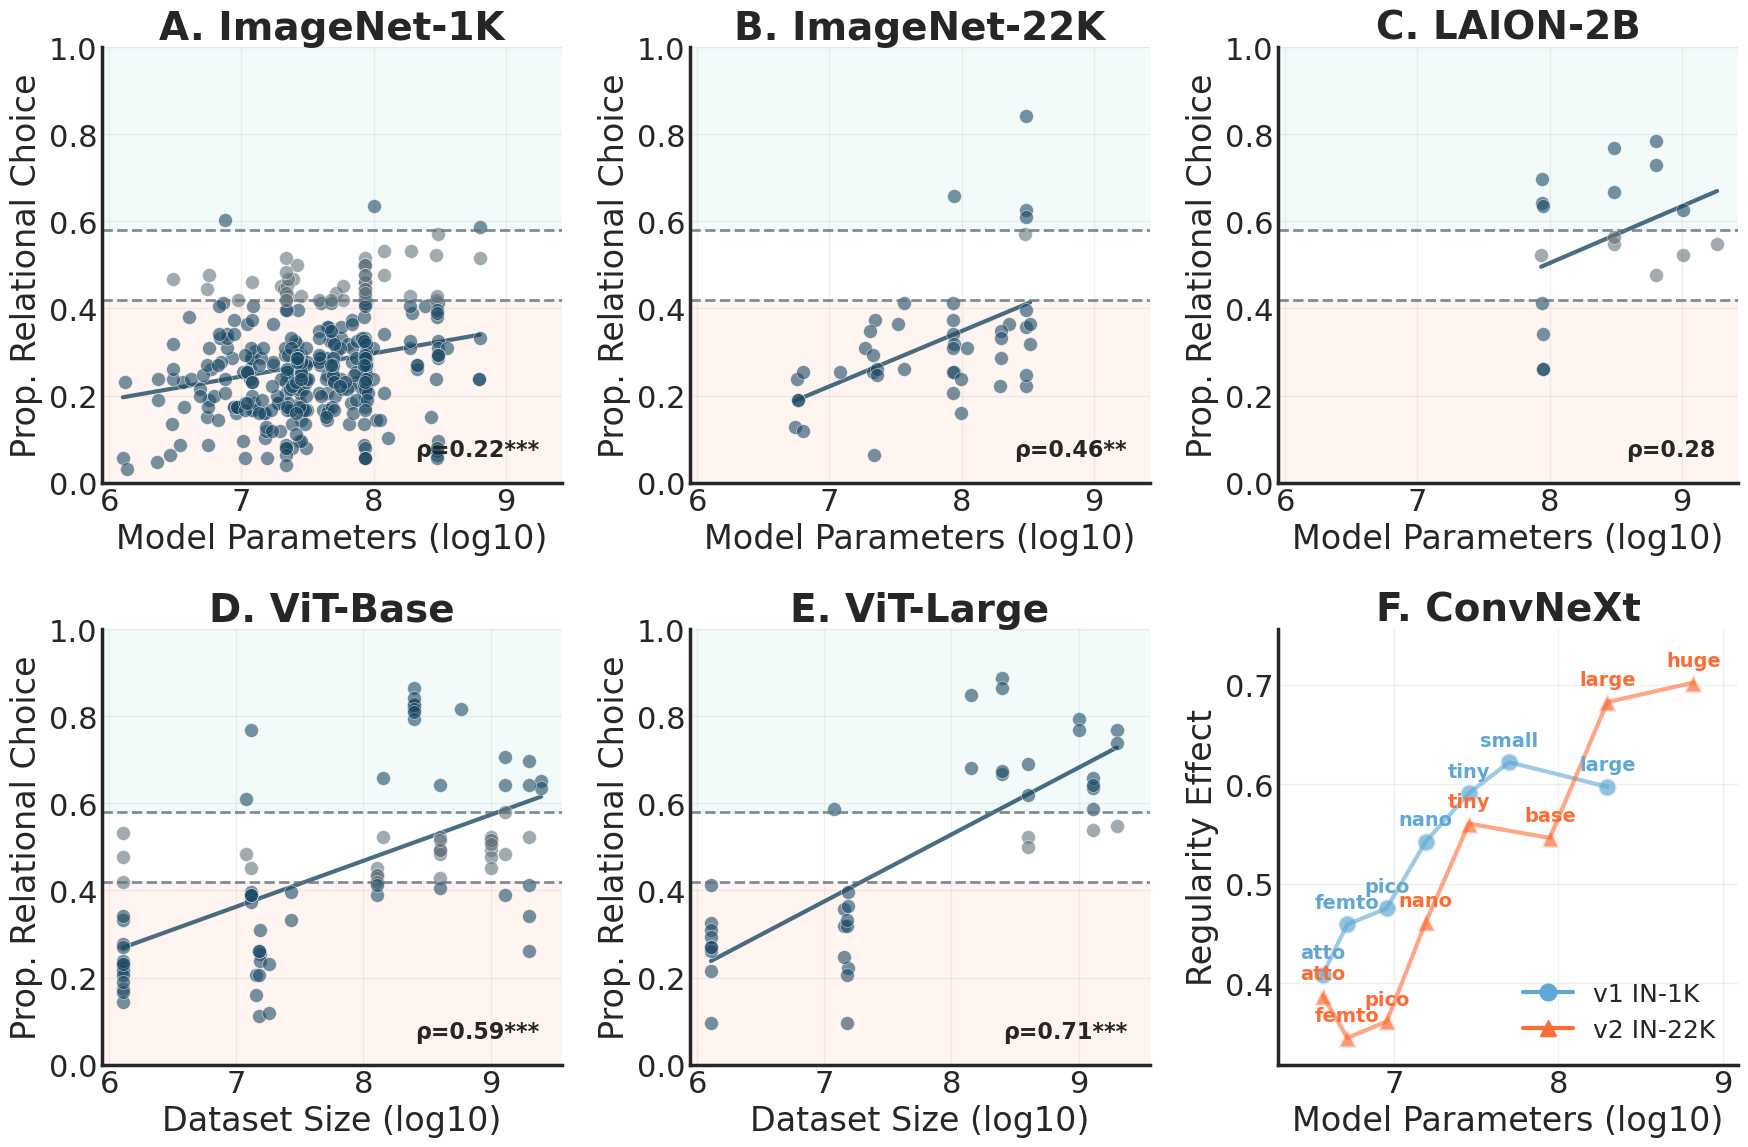

Saved: figures/figure_8.png


In [6]:
# Figure 8: Capacity Effects Within Fixed Architectures (Option 3: Modern Scientific)

plt.style.use('seaborn-v0_8-white')
plt.rcParams.update({
    'font.size': 24, 'axes.titlesize': 28, 'axes.labelsize': 26,
    'xtick.labelsize': 22, 'ytick.labelsize': 22, 'font.family': 'sans-serif',
    'axes.linewidth': 2.5, 'legend.fontsize': 18, 'axes.grid': True,
    'grid.alpha': 0.3, 'grid.linewidth': 1.0,
})

RELATIONAL_THRESHOLD = 0.5794; CONCRETE_THRESHOLD = 0.4206; YLIM = (0, 1)
palette = {'primary': '#1B4965', 'secondary': '#FF6B35', 'tertiary': '#5FA8D3',
           'grey': '#62727B', 'shading_top': '#BEE9E8', 'shading_bottom': '#FFCAB1'}

# Data helpers
all_trans = df[df['is_transformer'] == True].dropna(subset=['model_params_log10', 'relational_bias']).copy()
vit_modelsize = {
    'ImageNet-1k': all_trans[all_trans['dataset_name'].str.startswith('ImageNet-1k', na=False)],
    'ImageNet-22k': all_trans[all_trans['dataset_name'].str.startswith('ImageNet-22k', na=False)],
    'LAION-2B': all_trans[all_trans['dataset_name'].str.startswith('LAION-2B', na=False)],
}
exclude = ['efficientvit', 'bigG', 'coca', 'roberta', 'xlm']
vb = df['model_name'].str.contains('ViT_B|ViT-B|vit_base|vit_base_patch', case=False, na=False) & ~df['model_name'].str.contains('|'.join(exclude), case=False, na=False)
vl = df['model_name'].str.contains('ViT_L|ViT-L|vit_large|vit_large_patch', case=False, na=False) & ~df['model_name'].str.contains('|'.join(exclude), case=False, na=False)
vit_datasize = {
    'ViT-Base': df[vb].dropna(subset=['dataset_size_log10', 'relational_bias']).copy(),
    'ViT-Large': df[vl].dropna(subset=['dataset_size_log10', 'relational_bias']).copy(),
}
cnx_v1 = df[(df['model_name'].str.contains('convnext', case=False, na=False)) & (~df['model_name'].str.contains('convnextv2', case=False, na=False)) & (df['dataset_name'] == 'ImageNet-1k') & (df['source'] == 'timm')].copy()
cnx_v1 = cnx_v1[~cnx_v1['model_name'].str.contains('_ols|_hnf', case=False, na=False)].dropna(subset=['model_params_log10', 'diff_symbolic_r'])
cnx_v2 = df[df['model_name'].str.contains('convnextv2', case=False, na=False)].dropna(subset=['model_params_log10', 'diff_symbolic_r']).copy()
convnext_data = {'v1 IN-1k': cnx_v1, 'v2 IN-22k': cnx_v2}

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
CP, CS, CT, CG = palette['primary'], palette['secondary'], palette['tertiary'], palette['grey']
ST, SB = palette['shading_top'], palette['shading_bottom']

# x-axis ranges
all_xm = [v for d in vit_modelsize.values() for v in d['model_params_log10'].values if len(d) > 0]
xlim_m = (min(all_xm) - 0.05*(max(all_xm)-min(all_xm)), max(all_xm) + 0.05*(max(all_xm)-min(all_xm)))
all_xd = [v for d in vit_datasize.values() for v in d['dataset_size_log10'].values if len(d) > 0]
xlim_d = (min(all_xd) - 0.05*(max(all_xd)-min(all_xd)), max(all_xd) + 0.05*(max(all_xd)-min(all_xd)))

# Row 1: ViT Model Size by Dataset
ds_labels = {'ImageNet-1k': ('A', 'ImageNet-1K'), 'ImageNet-22k': ('B', 'ImageNet-22K'), 'LAION-2B': ('C', 'LAION-2B')}
for i, (dsn, data) in enumerate(vit_modelsize.items()):
    ax = axes[0, i]; lbl, ttl = ds_labels[dsn]
    if len(data) == 0: ax.set_title(f'{lbl}. {ttl}\n(No data)', fontweight='bold'); continue
    ax.set_ylim(YLIM); ax.set_xlim(xlim_m)
    ax.axhspan(RELATIONAL_THRESHOLD, 1, color=ST, alpha=0.2, zorder=0)
    ax.axhspan(0, CONCRETE_THRESHOLD, color=SB, alpha=0.2, zorder=0)
    x, y = data['model_params_log10'].values, data['relational_bias'].values
    for xi, yi in zip(x, y):
        c = CP if (yi >= RELATIONAL_THRESHOLD or yi <= CONCRETE_THRESHOLD) else CG
        ax.scatter(xi, yi, color=c, alpha=0.6, s=100, edgecolors='white', linewidth=0.5, zorder=2)
    if len(x) > 2:
        sl, ic, _, _, _ = stats.linregress(x, y)
        xl = np.linspace(x.min(), x.max(), 100)
        ax.plot(xl, sl*xl+ic, color=CP, linewidth=3, alpha=0.8, zorder=1)
        rho, p = stats.spearmanr(x, y)
        sig = '***' if p < 0.001 else ('**' if p < 0.01 else ('*' if p < 0.05 else ''))
        ax.text(0.95, 0.05, f'\u03c1={rho:.2f}{sig}', transform=ax.transAxes, ha='right', va='bottom', fontsize=16, fontweight='bold')
    ax.axhline(y=RELATIONAL_THRESHOLD, color=CG, linestyle='--', linewidth=2, alpha=0.8)
    ax.axhline(y=CONCRETE_THRESHOLD, color=CG, linestyle='--', linewidth=2, alpha=0.8)
    ax.set_xlabel('Model Parameters (log10)'); ax.set_ylabel('Prop. Relational Choice')
    ax.set_title(f'{lbl}. {ttl}', fontweight='bold')

# Row 2: ViT Dataset Size (D, E)
for i, (mt, data) in enumerate(vit_datasize.items()):
    ax = axes[1, i]; lbl = 'D' if i == 0 else 'E'
    ax.set_ylim(YLIM); ax.set_xlim(xlim_d)
    ax.axhspan(RELATIONAL_THRESHOLD, 1, color=ST, alpha=0.2, zorder=0)
    ax.axhspan(0, CONCRETE_THRESHOLD, color=SB, alpha=0.2, zorder=0)
    x, y = data['dataset_size_log10'].values, data['relational_bias'].values
    for xi, yi in zip(x, y):
        c = CP if (yi >= RELATIONAL_THRESHOLD or yi <= CONCRETE_THRESHOLD) else CG
        ax.scatter(xi, yi, color=c, alpha=0.6, s=100, edgecolors='white', linewidth=0.5, zorder=2)
    if len(x) > 2:
        sl, ic, _, _, _ = stats.linregress(x, y)
        xl = np.linspace(x.min(), x.max(), 100)
        ax.plot(xl, sl*xl+ic, color=CP, linewidth=3, alpha=0.8, zorder=1)
        rho, p = stats.spearmanr(x, y)
        sig = '***' if p < 0.001 else ('**' if p < 0.01 else ('*' if p < 0.05 else ''))
        ax.text(0.95, 0.05, f'\u03c1={rho:.2f}{sig}', transform=ax.transAxes, ha='right', va='bottom', fontsize=16, fontweight='bold')
    ax.axhline(y=RELATIONAL_THRESHOLD, color=CG, linestyle='--', linewidth=2, alpha=0.8)
    ax.axhline(y=CONCRETE_THRESHOLD, color=CG, linestyle='--', linewidth=2, alpha=0.8)
    ax.set_xlabel('Dataset Size (log10)'); ax.set_ylabel('Prop. Relational Choice')
    ax.set_title(f'{lbl}. {mt}', fontweight='bold')

# Panel F: ConvNeXt Regularity
ax = axes[1, 2]
vc = {'v1 IN-1k': CT, 'v2 IN-22k': CS}; vm = {'v1 IN-1k': 'o', 'v2 IN-22k': '^'}
all_xf, all_yf = [], []
for ver, data in convnext_data.items():
    x, y = data['model_params_log10'].values, data['diff_symbolic_r'].values
    all_xf.extend(x); all_yf.extend(y)
    ax.scatter(x, y, color=vc[ver], alpha=0.7, s=180, edgecolors='white', linewidth=2, marker=vm[ver])
    if len(x) > 1:
        si = np.argsort(x); ax.plot(x[si], y[si], color=vc[ver], linewidth=3, alpha=0.6)
    for _, row in data.iterrows():
        name = row['model_name'].lower().replace('convnext_', '').replace('convnextv2_', '')
        ax.annotate(name, (row['model_params_log10'], row['diff_symbolic_r']), textcoords='offset points', xytext=(0,12), ha='center', fontsize=14, fontweight='bold', color=vc[ver])
xp = (max(all_xf)-min(all_xf))*0.12; yp = (max(all_yf)-min(all_yf))*0.15
ax.set_xlim(min(all_xf)-xp, max(all_xf)+xp); ax.set_ylim(min(all_yf)-yp*0.5, max(all_yf)+yp)
ax.set_xlabel('Model Parameters (log10)'); ax.set_ylabel('Regularity Effect')
ax.set_title('F. ConvNeXt', fontweight='bold')
ax.legend(handles=[Line2D([0],[0],marker='o',color=CT,linestyle='-',markersize=12,linewidth=3,label='v1 IN-1K'),
                    Line2D([0],[0],marker='^',color=CS,linestyle='-',markersize=12,linewidth=3,label='v2 IN-22K')], loc='lower right')

plt.tight_layout()
plt.savefig('figures/figure_8.png', dpi=300, bbox_inches='tight')
plt.show()
print('Saved: figures/figure_8.png')

### Figure 9: Random Forest Feature Importance and SHAP

A 2x3 panel figure:
- **Top row**: Aggregated RF permutation importance (scaled by CV R-squared)
- **Bottom row**: SHAP beeswarm plots showing feature value effects

Training on 1204 samples...
  Semantic Distance Effect: CV R2 = 0.151
  Regularity Effect: CV R2 = 0.580
  Relational Bias: CV R2 = 0.530


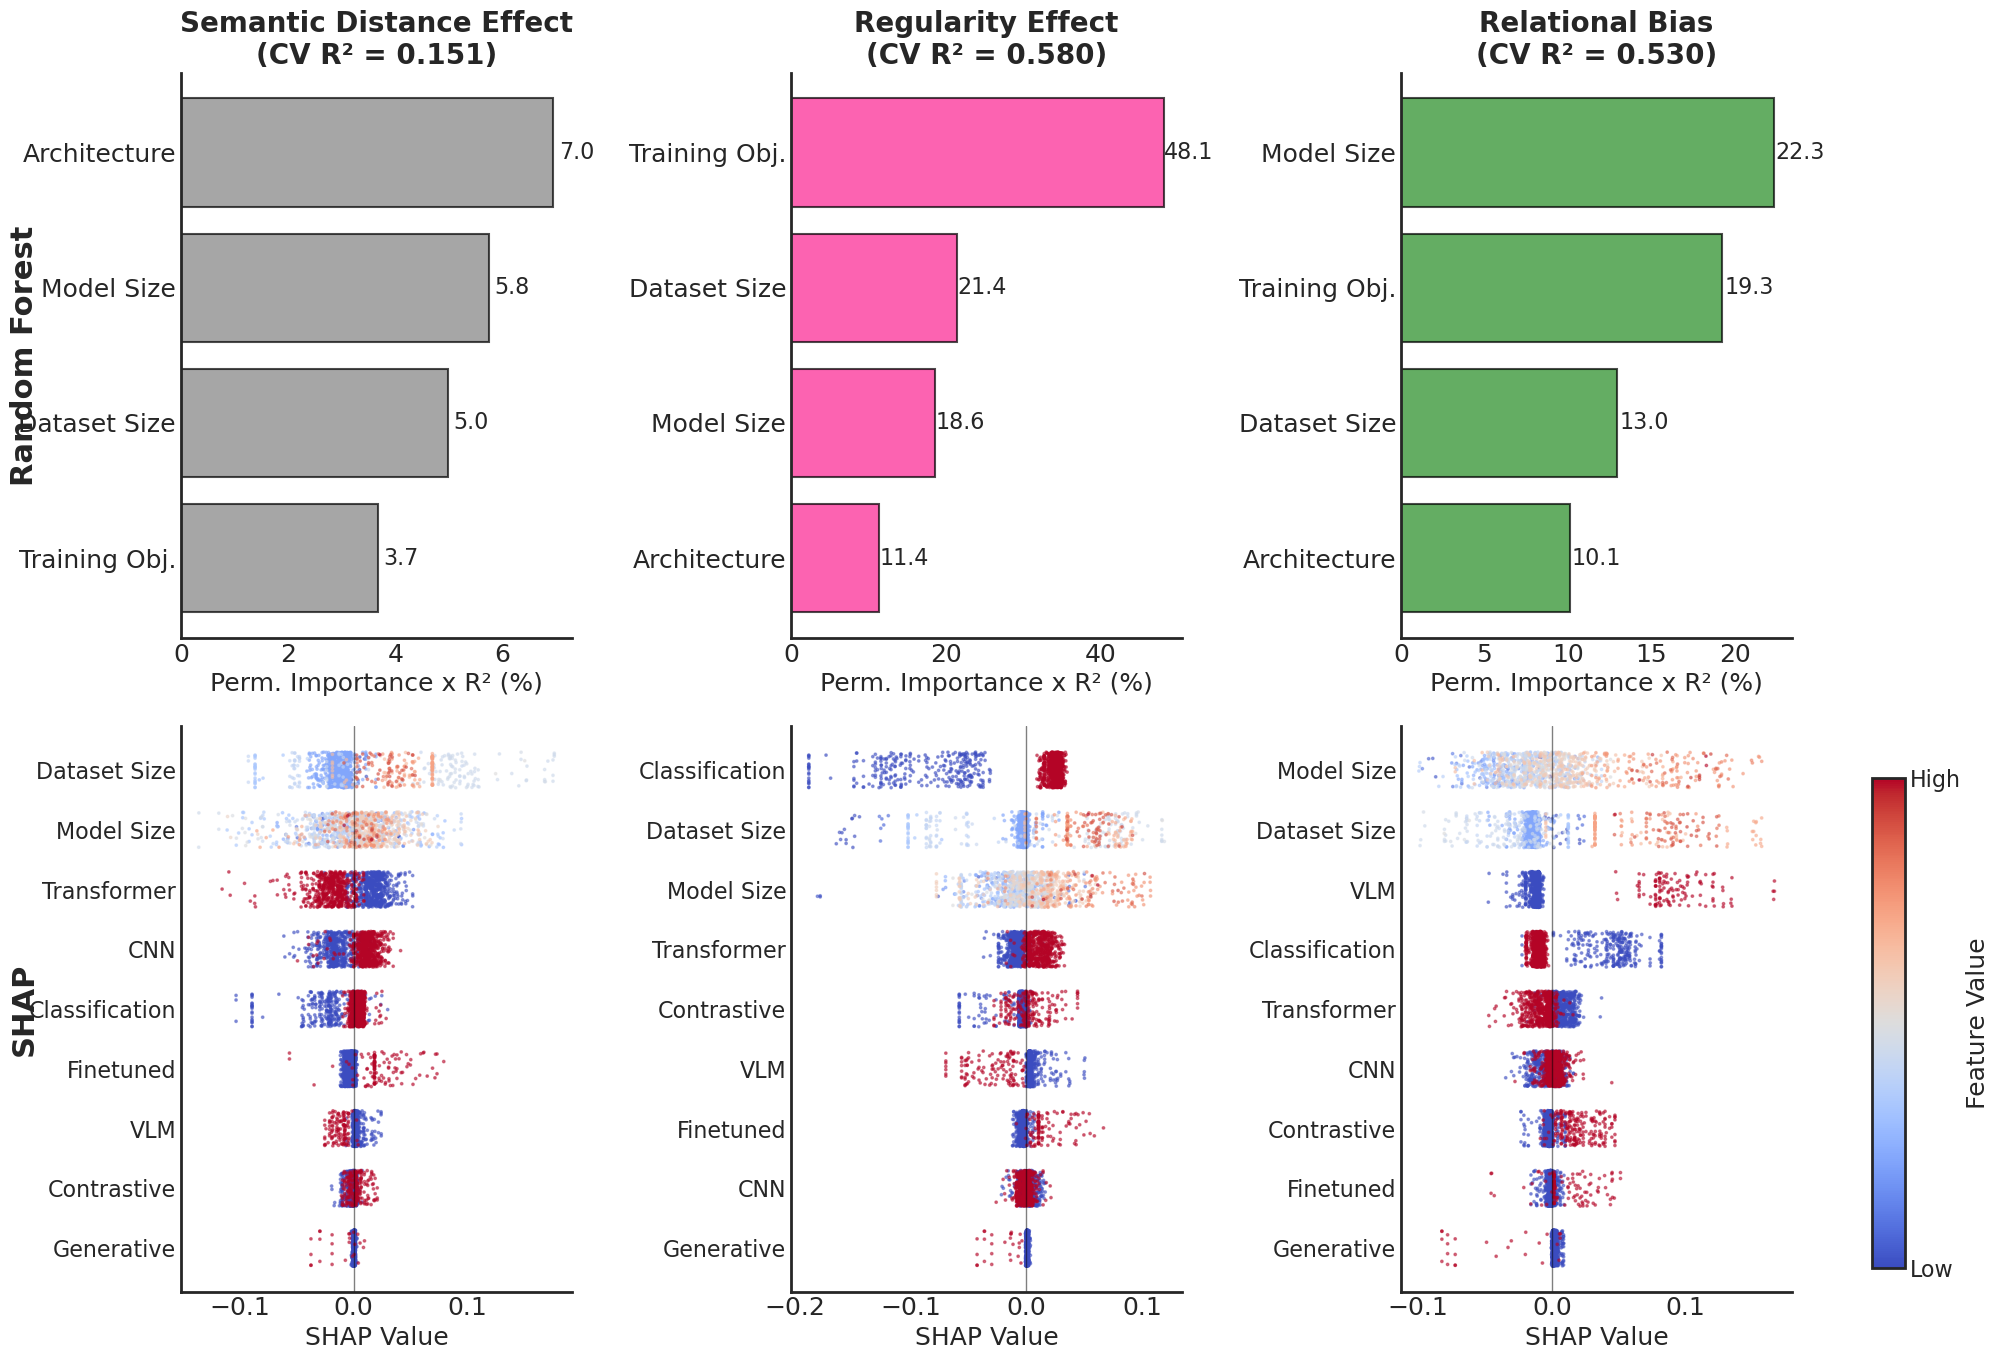

Saved: figures/figure_9.png


In [7]:
# Figure 9: RF Feature Importance + SHAP Beeswarm

plt.style.use('seaborn-v0_8-white')
plt.rcParams.update({
    'font.size': 20, 'axes.titlesize': 24, 'axes.labelsize': 22,
    'xtick.labelsize': 18, 'ytick.labelsize': 18, 'figure.titlesize': 28,
    'font.family': 'sans-serif', 'axes.linewidth': 2.0, 'legend.fontsize': 18,
    'axes.grid': False,
})

TASK_COLORS = {'sem_dist_effect': '#808080', 'diff_symbolic_r': '#fc2190', 'relational_bias': '#238b21'}
TASK_LABELS = {'sem_dist_effect': 'Semantic Distance Effect', 'diff_symbolic_r': 'Regularity Effect', 'relational_bias': 'Relational Bias'}
FEAT_NAMES = {'model_params_log10': 'Model Size', 'dataset_size_log10': 'Dataset Size', 'is_cnn': 'CNN',
              'is_transformer': 'Transformer', 'is_vlm': 'VLM', 'is_classification': 'Classification',
              'is_contrastive': 'Contrastive', 'is_generative': 'Generative', 'is_finetuned': 'Finetuned'}

cont_pred = ['dataset_size_log10', 'model_params_log10']
bin_pred = ['is_classification', 'is_contrastive', 'is_generative', 'is_vlm', 'is_finetuned', 'is_cnn', 'is_transformer']
all_pred = cont_pred + bin_pred
targets = ['sem_dist_effect', 'diff_symbolic_r', 'relational_bias']

for col in bin_pred:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df_c9 = df.dropna(subset=all_pred + targets).copy()
X9 = df_c9[all_pred].astype(float).values
X9_df = df_c9[all_pred].astype(float)

ARCH_IDX = [all_pred.index(f) for f in ['is_cnn', 'is_transformer']]
TRAIN_IDX = [all_pred.index(f) for f in ['is_finetuned', 'is_contrastive', 'is_vlm', 'is_generative', 'is_classification']]
DS_IDX, MP_IDX = all_pred.index('dataset_size_log10'), all_pred.index('model_params_log10')

print(f'Training on {len(df_c9)} samples...')
rf9 = {}; cv_r2 = {}; perm_imp = {}; shap_vals = {}
for t in targets:
    y = df_c9[t].values
    rf = RandomForestRegressor(n_estimators=500, max_depth=None, min_samples_split=5, min_samples_leaf=2, max_features='sqrt', random_state=42, n_jobs=-1)
    rf.fit(X9, y); rf9[t] = rf
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_r2[t] = np.mean(cross_val_score(rf, X9, y, cv=kf, scoring='r2'))
    perm_imp[t] = permutation_importance(rf, X9, y, n_repeats=30, random_state=42, n_jobs=-1).importances_mean
    shap_vals[t] = shap.TreeExplainer(rf).shap_values(X9)
    print(f'  {TASK_LABELS[t]}: CV R2 = {cv_r2[t]:.3f}')

fig, axes = plt.subplots(2, 3, figsize=(22, 14))
# Top: Aggregated importance
for col, t in enumerate(targets):
    ax = axes[0, col]; color = TASK_COLORS[t]; pm = perm_imp[t]; r2 = cv_r2[t]
    agg = {'Dataset Size': pm[DS_IDX]*100, 'Model Size': pm[MP_IDX]*100,
           'Architecture': sum(pm[i] for i in ARCH_IDX)*100, 'Training Obj.': sum(pm[i] for i in TRAIN_IDX)*100}
    si = sorted(agg.items(), key=lambda x: x[1], reverse=True)
    names, vals = [k for k,v in si], [v*r2 for k,v in si]
    yp = np.arange(len(names))
    bars = ax.barh(yp, vals, color=color, alpha=0.7, edgecolor='black', linewidth=1.5)
    for bar, val in zip(bars, vals): ax.text(val+0.1, bar.get_y()+bar.get_height()/2, f'{val:.1f}', va='center', fontsize=16)
    ax.axvline(x=0, color='black', linestyle='-', linewidth=1.5, alpha=0.8)
    ax.set_yticks(yp); ax.set_yticklabels(names, fontsize=18)
    ax.set_xlabel('Perm. Importance x R\u00b2 (%)', fontsize=18)
    ax.set_title(f'{TASK_LABELS[t]}\n(CV R\u00b2 = {r2:.3f})', fontweight='bold', fontsize=20)
    ax.invert_yaxis()
    if col == 0: ax.annotate('Random Forest', xy=(-0.4, 0.5), xycoords='axes fraction', fontsize=22, fontweight='bold', ha='center', va='center', rotation=90)

# Bottom: SHAP beeswarm
for col, t in enumerate(targets):
    ax = axes[1, col]; sv = shap_vals[t]
    disp = [FEAT_NAMES.get(f, f) for f in all_pred]
    mean_abs = np.abs(sv).mean(axis=0); si = np.argsort(mean_abs)
    for i, fi in enumerate(si):
        sc, fc = sv[:, fi], X9[:, fi]
        fmin, fmax = fc.min(), fc.max()
        fn = (fc - fmin) / (fmax - fmin) if fmax > fmin else np.zeros_like(fc)
        jitter = np.random.RandomState(42).uniform(-0.3, 0.3, size=len(sc))
        order = np.argsort(fn)
        ax.scatter(sc[order], np.full(len(sc), i)+jitter[order], c=fn[order], cmap='coolwarm', s=3, alpha=0.5, vmin=0, vmax=1, rasterized=True)
    ax.axvline(x=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
    ax.set_yticks(range(len(si))); ax.set_yticklabels([disp[j] for j in si], fontsize=16)
    ax.set_xlabel('SHAP Value', fontsize=18)
    if col == 0: ax.annotate('SHAP', xy=(-0.4, 0.5), xycoords='axes fraction', fontsize=22, fontweight='bold', ha='center', va='center', rotation=90)

cbar_ax = fig.add_axes([0.93, 0.08, 0.015, 0.35])
sm_ = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(0, 1)); sm_.set_array([])
cbar = fig.colorbar(sm_, cax=cbar_ax); cbar.set_ticks([0, 1]); cbar.set_ticklabels(['Low', 'High'], fontsize=16); cbar.set_label('Feature Value', fontsize=18)
plt.tight_layout(rect=[0.05, 0, 0.92, 1])
plt.savefig('figures/figure_9.png', dpi=300, bbox_inches='tight')
plt.show()
print('Saved: figures/figure_9.png')

### Figure 10: GAM Analysis (Deviance Reduction and Partial Dependence)

A 2x3 panel figure (moderate smoothing: n_splines=7, lambda=0.8):
- **Top row**: Deviance reduction bars (contribution to R-squared)
- **Bottom row**: Partial dependence with dual x-axes (dataset size + model size)

Computing GAM deviance reduction (n_splines=7, lambda=0.8)...
  Semantic Distance Effect...


  Regularity Effect...


  Relational Bias...


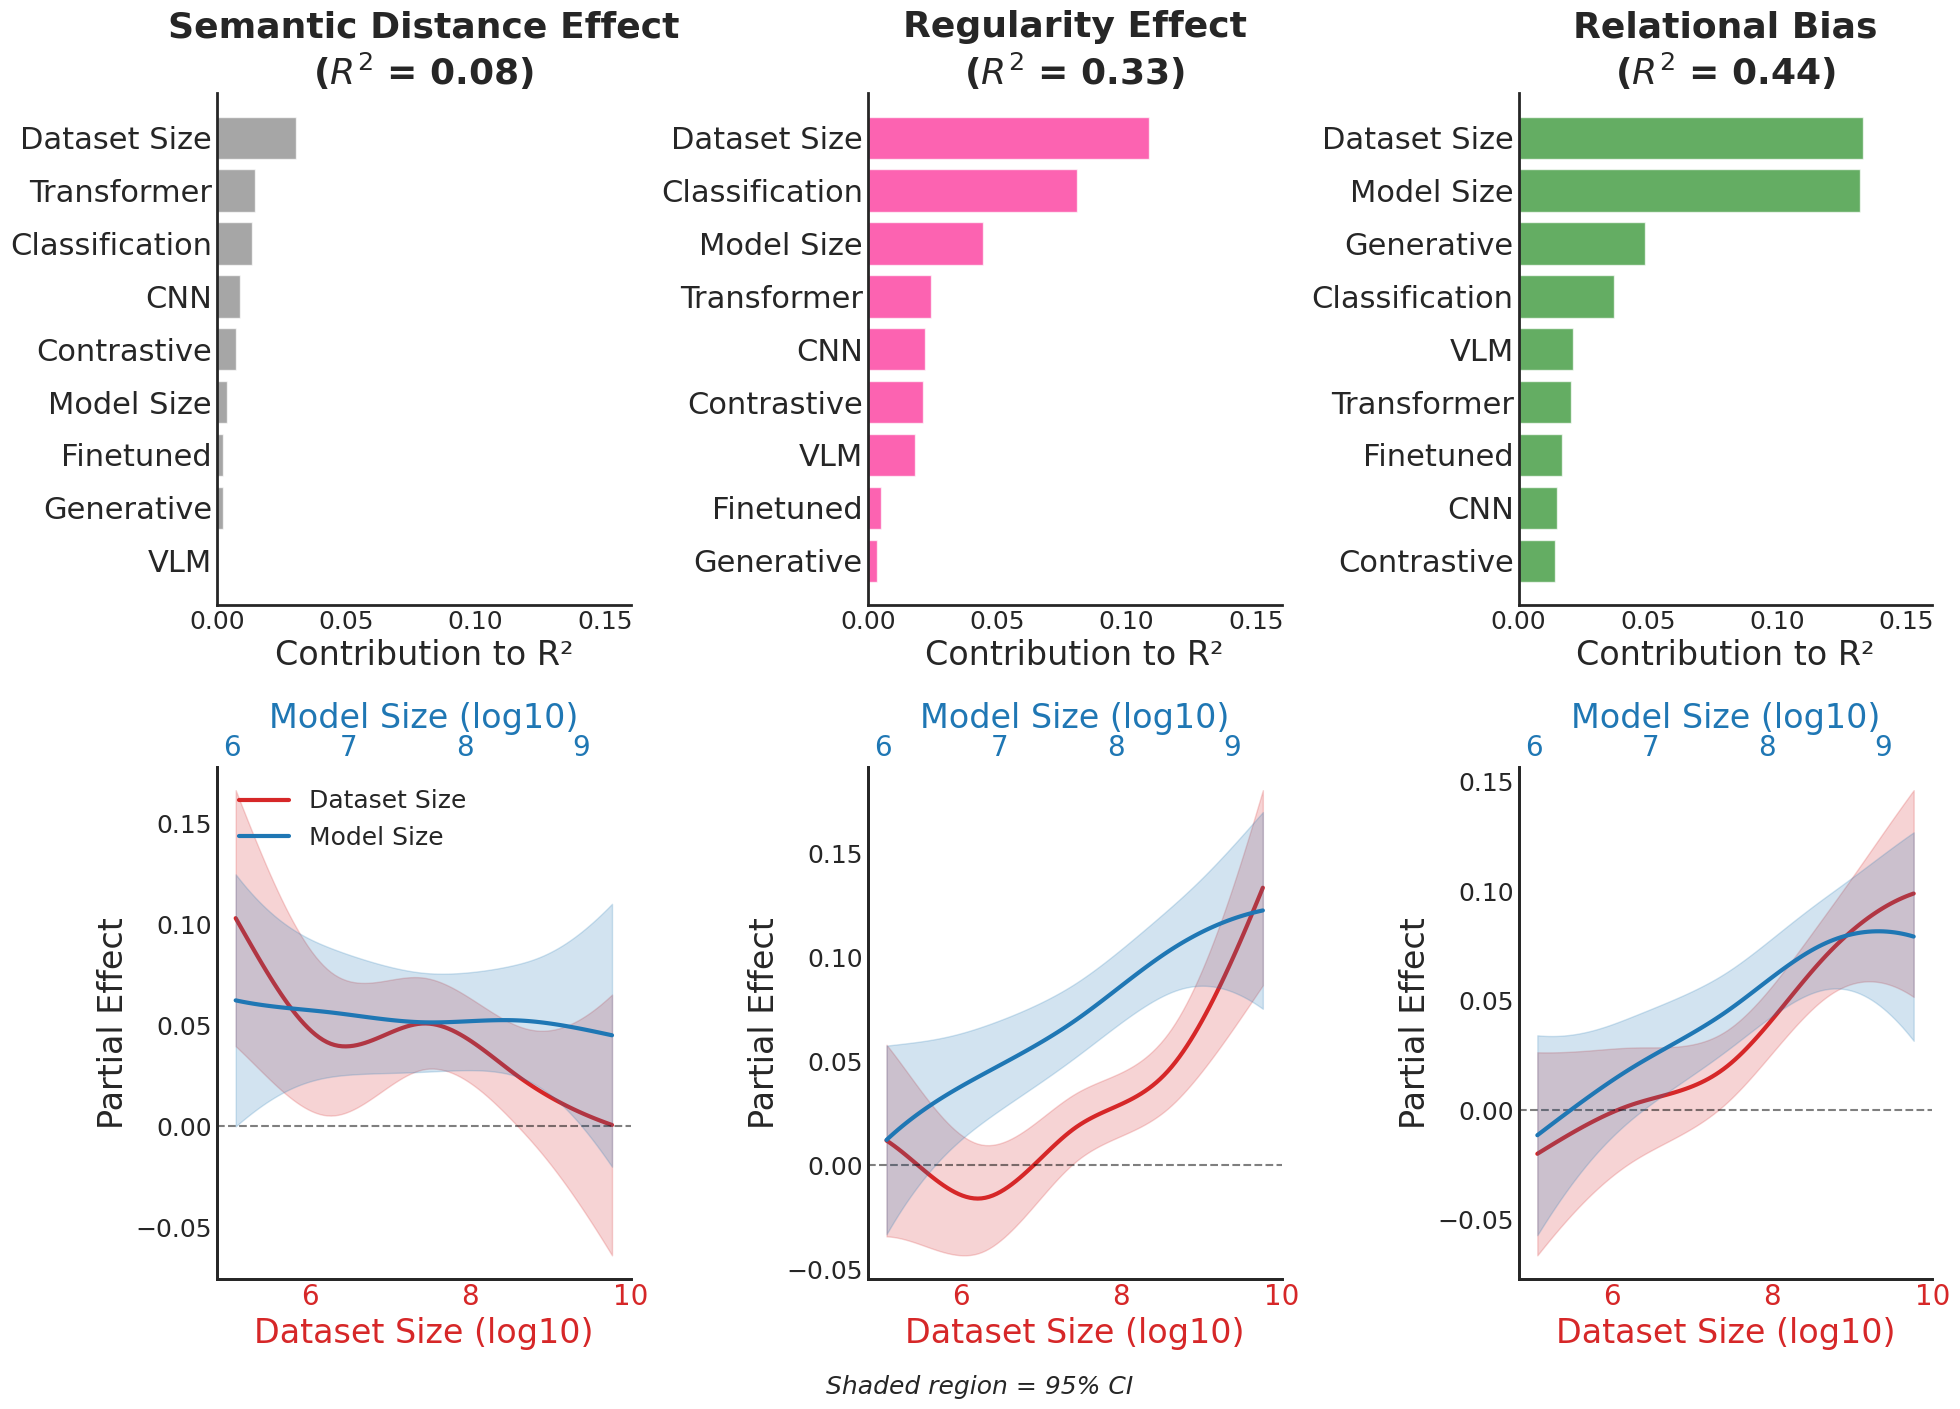

Saved: figures/figure_10.png


In [8]:
# Figure 10: GAM Deviance Reduction (moderate smoothing)

plt.style.use('seaborn-v0_8-white')
plt.rcParams.update({
    'font.size': 20, 'axes.titlesize': 24, 'axes.labelsize': 22,
    'xtick.labelsize': 18, 'ytick.labelsize': 18, 'figure.titlesize': 28,
    'font.family': 'sans-serif', 'axes.linewidth': 2.0, 'legend.fontsize': 18,
    'axes.grid': False,
})

TASK_COLORS10 = {'sem_dist_effect': '#808080', 'diff_symbolic_r': '#fc2190', 'relational_bias': '#238b21'}
TASK_LABELS10 = {'sem_dist_effect': 'Semantic Distance Effect', 'diff_symbolic_r': 'Regularity Effect', 'relational_bias': 'Relational Bias'}
PRED_LABELS = {'dataset_size_log10': 'Dataset Size', 'model_params_log10': 'Model Size',
               'is_classification': 'Classification', 'is_contrastive': 'Contrastive', 'is_generative': 'Generative',
               'is_vlm': 'VLM', 'is_finetuned': 'Finetuned', 'is_cnn': 'CNN', 'is_transformer': 'Transformer'}
TRAIN_OBJ = ['is_finetuned', 'is_contrastive', 'is_vlm', 'is_generative', 'is_classification']

n_sp, lam = 7, 0.8  # moderate smoothing

def build_gam_terms10(n_splines, lam):
    return s(0, n_splines=n_splines, lam=lam) + s(1, n_splines=n_splines, lam=lam) + f(2) + f(3) + f(4) + f(5) + f(6) + f(7) + f(8) + te(0,7) + te(0,8) + te(1,7) + te(1,8)

def compute_deviance_importance10(X, y, n_splines, lam):
    full_gam = LinearGAM(build_gam_terms10(n_splines, lam)); full_gam.fit(X, y)
    full_dev = full_gam.statistics_['pseudo_r2']['explained_deviance']
    term_info = [(0,'dataset_size_log10','s'),(1,'model_params_log10','s'),(2,'is_classification','f'),(3,'is_contrastive','f'),(4,'is_generative','f'),(5,'is_vlm','f'),(6,'is_finetuned','f'),(7,'is_cnn','f'),(8,'is_transformer','f')]
    importance = {}
    for idx, name, tt in term_info:
        terms_list = []
        for i, n, t in term_info:
            if i != idx:
                terms_list.append(s(i, n_splines=n_splines, lam=lam) if t == 's' else f(i))
        if idx not in [0,7]: terms_list.append(te(0,7))
        if idx not in [0,8]: terms_list.append(te(0,8))
        if idx not in [1,7]: terms_list.append(te(1,7))
        if idx not in [1,8]: terms_list.append(te(1,8))
        rt = terms_list[0]
        for t in terms_list[1:]: rt = rt + t
        try:
            rg = LinearGAM(rt); rg.fit(X, y)
            importance[name] = (full_dev - rg.statistics_['pseudo_r2']['explained_deviance']) * 100
        except: importance[name] = 0
    return importance, full_dev

# Use X9 and df_c9 from Figure 9 cell
print(f'Computing GAM deviance reduction (n_splines={n_sp}, lambda={lam})...')
results10 = {}; dev_imp10 = {}
for target in targets:
    print(f'  {TASK_LABELS10[target]}...')
    y = df_c9[target].values
    gam = LinearGAM(build_gam_terms10(n_sp, lam)); gam.fit(X9, y)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = []
    for train_idx, test_idx in kf.split(X9):
        gam_cv = LinearGAM(build_gam_terms10(n_sp, lam)); gam_cv.fit(X9[train_idx], y[train_idx])
        cv_scores.append(r2_score(y[test_idx], gam_cv.predict(X9[test_idx])))
    results10[target] = {'model': gam, 'cv_r2': np.mean(cv_scores)}
    imp, _ = compute_deviance_importance10(X9, y, n_sp, lam)
    dev_imp10[target] = imp

fig, axes = plt.subplots(2, 3, figsize=(20, 14))
# Row 1: Deviance Reduction
for col, target in enumerate(targets):
    ax = axes[0, col]; color = TASK_COLORS10[target]; cv_r2_val = results10[target]['cv_r2']
    imp = dev_imp10[target]
    si = sorted(imp.items(), key=lambda x: x[1], reverse=True)
    names = [PRED_LABELS.get(k, k) for k, v in si]; raw = [v for k, v in si]
    total = sum(raw)
    scaled = [v / total * cv_r2_val for v in raw] if total > 0 else raw
    yp = np.arange(len(names))
    ax.barh(yp, scaled, color=color, alpha=0.7)
    ax.axvline(x=0, color='black', linestyle='-', linewidth=1.5, alpha=0.8)
    ax.set_yticks(yp); ax.set_yticklabels(names, fontsize=22)
    ax.set_xlabel('Contribution to R\u00b2', fontsize=24)
    ax.set_title(f'{TASK_LABELS10[target]}\n($R^2$ = {cv_r2_val:.2f})', fontweight='bold', fontsize=26)
    ax.set_xlim(0, 0.16); ax.set_xticks([0.00, 0.05, 0.10, 0.15]); ax.invert_yaxis()

# Row 2: Partial Dependence
C_DS, C_MP = '#d62728', '#1f77b4'
for col, target in enumerate(targets):
    ax = axes[1, col]; gam = results10[target]['model']
    XX_d = gam.generate_X_grid(term=0, n=100); pdep_d, ci_d = gam.partial_dependence(term=0, X=XX_d, width=0.95)
    XX_m = gam.generate_X_grid(term=1, n=100); pdep_m, ci_m = gam.partial_dependence(term=1, X=XX_m, width=0.95)
    l1, = ax.plot(XX_d[:, 0], pdep_d, color=C_DS, linewidth=3, label='Dataset Size')
    ax.fill_between(XX_d[:, 0], ci_d[:, 0], ci_d[:, 1], color=C_DS, alpha=0.2)
    ax.set_xlabel('Dataset Size (log10)', fontsize=24, color=C_DS)
    ax.tick_params(axis='x', labelsize=20, colors=C_DS); ax.set_ylabel('Partial Effect', fontsize=24)
    ax2 = ax.twiny()
    l2, = ax2.plot(XX_m[:, 1], pdep_m, color=C_MP, linewidth=3, label='Model Size')
    ax2.fill_between(XX_m[:, 1], ci_m[:, 0], ci_m[:, 1], color=C_MP, alpha=0.2)
    ax2.set_xlabel('Model Size (log10)', fontsize=24, color=C_MP)
    ax2.tick_params(axis='x', labelsize=20, colors=C_MP)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1.5, alpha=0.5)
    if col == 0: ax.legend([l1, l2], ['Dataset Size', 'Model Size'], loc='upper left', fontsize=18)

fig.text(0.5, -0.01, 'Shaded region = 95% CI', ha='center', fontsize=18, style='italic')
plt.tight_layout()
plt.savefig('figures/figure_10.png', dpi=300, bbox_inches='tight')
plt.show()
print('Saved: figures/figure_10.png')

### Figure 11: Language Supervision Effects (VLM vs Vision-Only)

Boxplots comparing VLM vs non-VLM models with matched backbones.
Architectures: ViT-Base, ViT-Large, ConvNeXt-Base, ConvNeXt-Large.

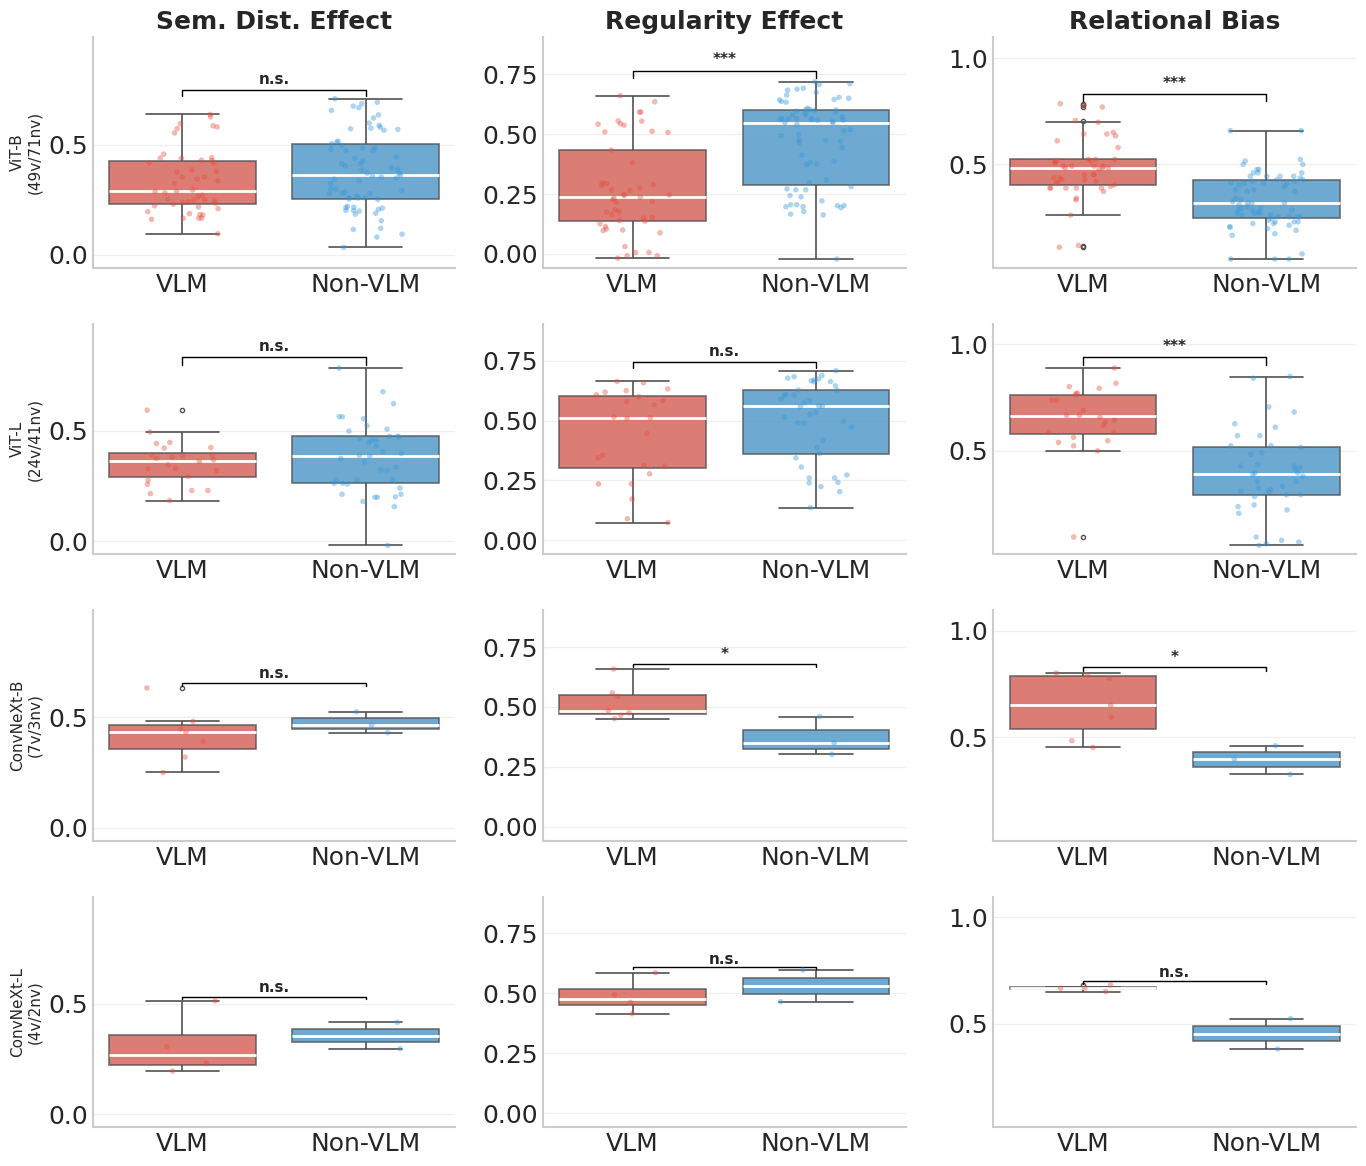

Saved: figures/figure_11.png


In [9]:
# Figure 11: VLM vs Vision-Only Comparison

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.size': 18, 'axes.titlesize': 24, 'axes.labelsize': 20,
    'xtick.labelsize': 18, 'ytick.labelsize': 18, 'figure.titlesize': 28,
    'font.family': 'sans-serif', 'axes.linewidth': 1.5, 'legend.fontsize': 16,
    'axes.spines.top': False, 'axes.spines.right': False, 'grid.alpha': 0.3,
})

metrics11 = ['sem_dist_effect', 'diff_symbolic_r', 'relational_bias']
metric_labels11 = {'sem_dist_effect': 'Sem. Dist. Effect', 'diff_symbolic_r': 'Regularity Effect', 'relational_bias': 'Relational Bias'}
VLM_COLOR, NON_VLM_COLOR = '#E74C3C', '#3498DB'

arch_families = {
    'ViT-B': {'params_range': (7.93, 7.95), 'is_transformer': True},
    'ViT-L': {'params_range': (8.47, 8.50), 'is_transformer': True},
    'ConvNeXt-B': {'name_pattern': 'convnext_base', 'is_transformer': False},
    'ConvNeXt-L': {'name_pattern': 'convnext_large', 'is_transformer': False},
}
arch_data = {}
for an, cfg in arch_families.items():
    if 'params_range' in cfg:
        mask = (df['model_params_log10'] >= cfg['params_range'][0]) & (df['model_params_log10'] <= cfg['params_range'][1]) & (df['is_transformer'] == cfg['is_transformer'])
    else:
        mask = df['model_name'].str.contains(cfg['name_pattern'], case=False, na=False)
    subset = df[mask].copy()
    vlm, non_vlm = subset[subset['is_vlm'] == True], subset[subset['is_vlm'] == False]
    if len(vlm) > 0 and len(non_vlm) > 0:
        arch_data[an] = {'vlm': vlm, 'non_vlm': non_vlm}

# Compute y-ranges
y_ranges = {}
for m in metrics11:
    vals = [v for d in arch_data.values() for v in list(d['vlm'][m].dropna()) + list(d['non_vlm'][m].dropna())]
    yr = max(vals) - min(vals)
    y_ranges[m] = (min(vals) - 0.05*yr, max(vals) + 0.25*yr)

n_arch = len(arch_data)
fig, axes = plt.subplots(n_arch, 3, figsize=(14, 3 * n_arch))
for row, (an, data) in enumerate(arch_data.items()):
    for col, m in enumerate(metrics11):
        ax = axes[row, col] if n_arch > 1 else axes[col]
        plot_data = []
        for _, r in data['vlm'].iterrows():
            if pd.notna(r[m]): plot_data.append({'Type': 'VLM', 'Value': r[m]})
        for _, r in data['non_vlm'].iterrows():
            if pd.notna(r[m]): plot_data.append({'Type': 'Non-VLM', 'Value': r[m]})
        pdf = pd.DataFrame(plot_data)
        sns.boxplot(data=pdf, x='Type', y='Value', palette={'VLM': VLM_COLOR, 'Non-VLM': NON_VLM_COLOR}, ax=ax, linewidth=1.2, fliersize=3, boxprops=dict(alpha=0.8), medianprops=dict(color='white', linewidth=2))
        sns.stripplot(data=pdf, x='Type', y='Value', palette={'VLM': VLM_COLOR, 'Non-VLM': NON_VLM_COLOR}, ax=ax, alpha=0.4, size=4, jitter=0.2)
        vlm_v, nv_v = data['vlm'][m].dropna().values, data['non_vlm'][m].dropna().values
        if len(vlm_v) > 1 and len(nv_v) > 1:
            stat, pv = stats.mannwhitneyu(vlm_v, nv_v, alternative='two-sided')
            sig = '***' if pv < 0.001 else '**' if pv < 0.01 else '*' if pv < 0.05 else 'n.s.'
            ym = pdf['Value'].max(); yr = pdf['Value'].max() - pdf['Value'].min()
            ax.plot([0,0,1,1], [ym+0.02*yr, ym+0.06*yr, ym+0.06*yr, ym+0.02*yr], color='black', linewidth=1)
            ax.text(0.5, ym+0.08*yr, sig, ha='center', va='bottom', fontsize=11, fontweight='bold')
        ax.set_ylim(y_ranges[m])
        if row == 0: ax.set_title(metric_labels11[m], fontweight='bold', fontsize=18)
        if col == 0: ax.set_ylabel(f'{an}\n({len(data["vlm"])}v/{len(data["non_vlm"])}nv)', fontsize=11)
        else: ax.set_ylabel('')
        ax.set_xlabel('')

plt.tight_layout()
plt.savefig('figures/figure_11.png', dpi=300, bbox_inches='tight')
plt.show()
print('Saved: figures/figure_11.png')

### Figure 12: Simulated Partial Dependence Plots

A 2x3 panel figure:
- **Top row**: GAM partial dependence
- **Bottom row**: Random Forest partial dependence
- Each subplot shows dataset size (bottom x-axis, red) and model params (top x-axis, blue)

Fitting models for partial dependence...


Computing partial dependence...


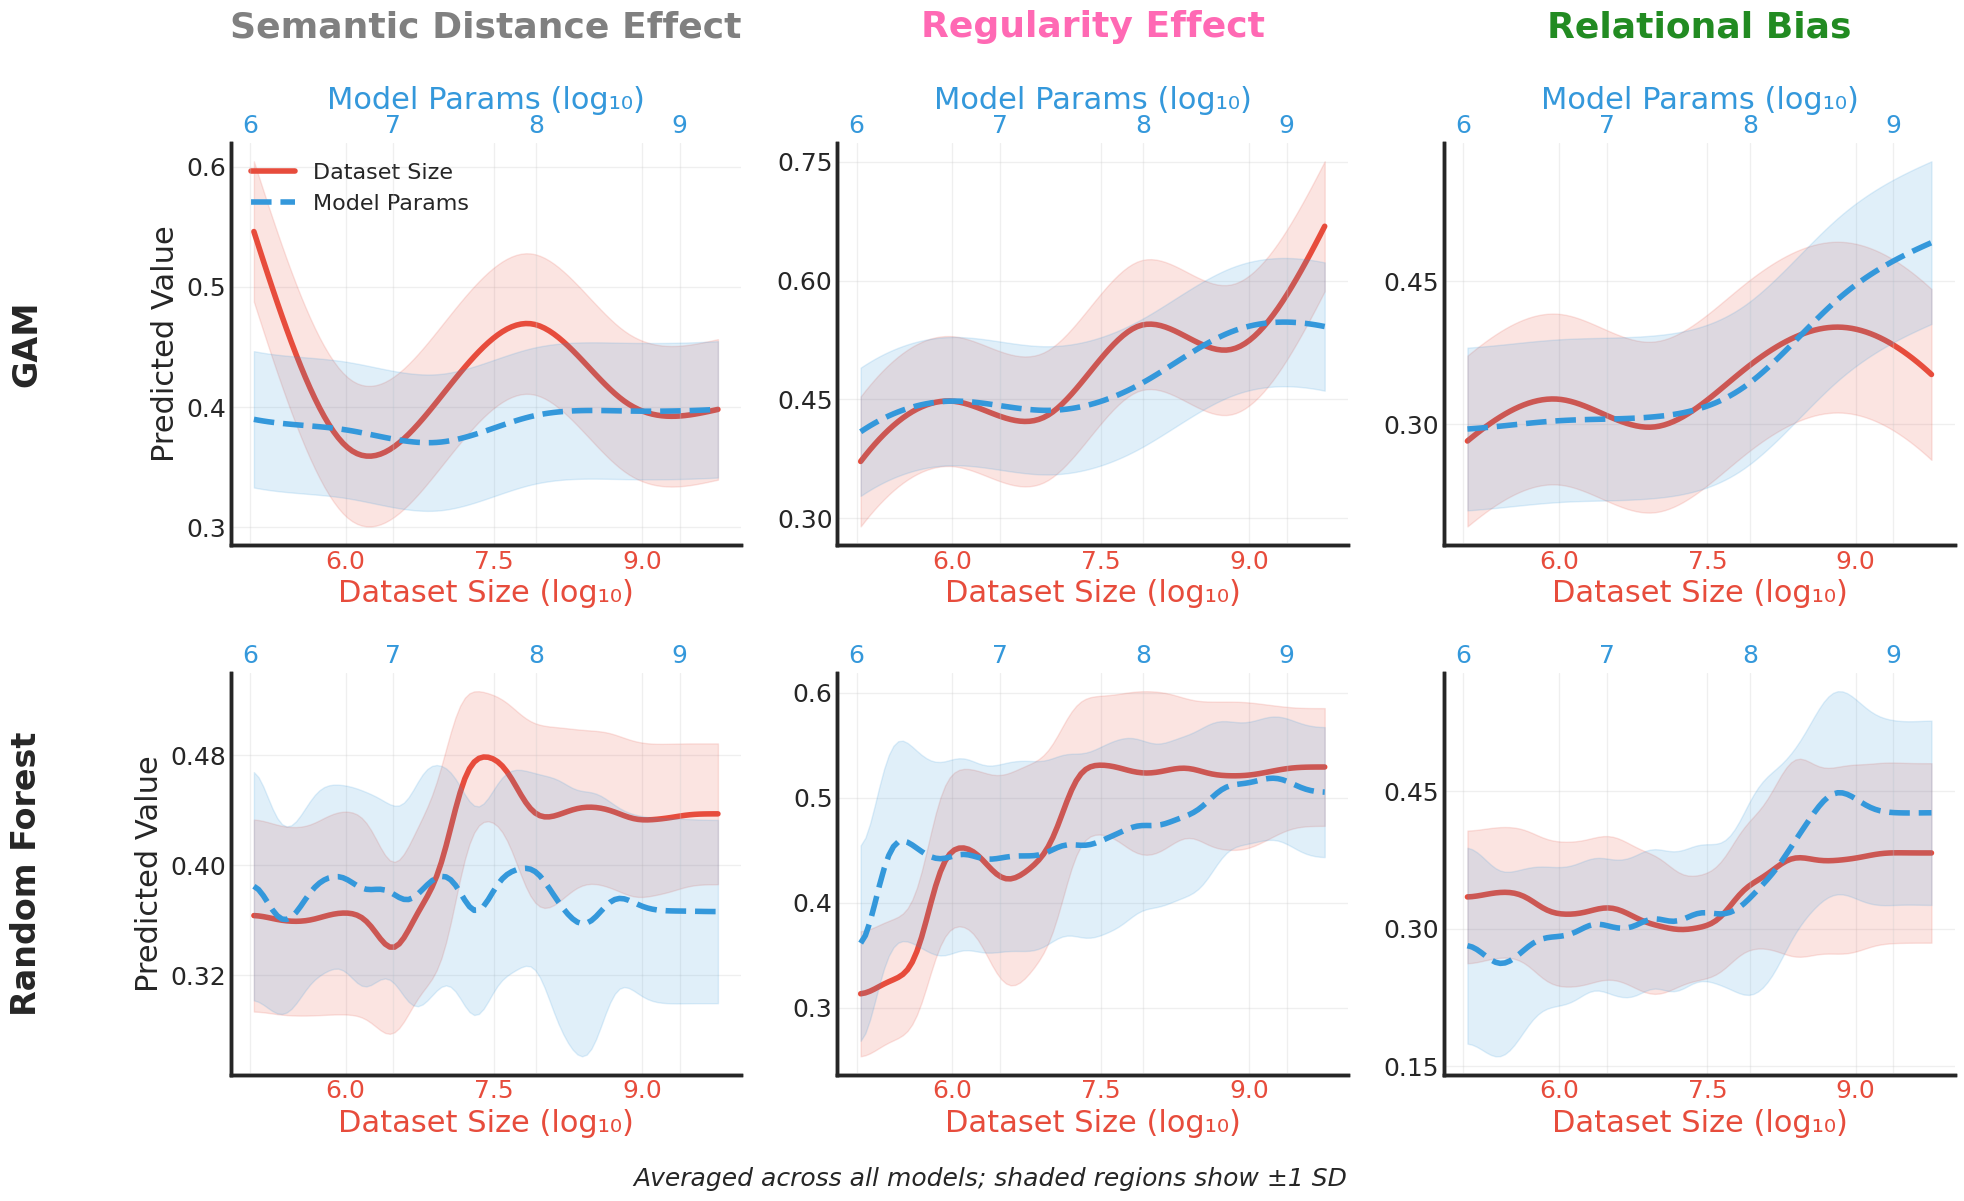

Saved: figures/figure_12.png


In [10]:
# Figure 12: Simulated Partial Dependence

plt.style.use('seaborn-v0_8-white')
plt.rcParams.update({
    'font.size': 24, 'axes.titlesize': 28, 'axes.labelsize': 24,
    'xtick.labelsize': 20, 'ytick.labelsize': 20, 'figure.titlesize': 32,
    'font.family': 'sans-serif', 'axes.linewidth': 2.5, 'legend.fontsize': 18,
    'axes.grid': True, 'grid.alpha': 0.3, 'grid.linewidth': 1.0,
})

OC = {'sem_dist_effect': '#808080', 'diff_symbolic_r': '#FF69B4', 'relational_bias': '#228B22'}
OL = {'sem_dist_effect': 'Semantic Distance Effect', 'diff_symbolic_r': 'Regularity Effect', 'relational_bias': 'Relational Bias'}

def build_gam12(n_splines=8, lam=0.6):
    return s(0, n_splines=n_splines, lam=lam) + s(1, n_splines=n_splines, lam=lam) + f(2) + f(3) + f(4) + f(5) + f(6) + f(7) + f(8)

# Fit GAM and RF models
print('Fitting models for partial dependence...')
gam12, rf12 = {}, {}
for t in targets:
    y = df_c9[t].values
    g = LinearGAM(build_gam12()); g.fit(X9, y); gam12[t] = g
    r = RandomForestRegressor(n_estimators=500, max_depth=None, min_samples_split=5, min_samples_leaf=2, max_features='sqrt', random_state=42, n_jobs=-1)
    r.fit(X9, y); rf12[t] = r

ds_range = np.linspace(df_c9['dataset_size_log10'].min(), df_c9['dataset_size_log10'].max(), 100)
mp_range = np.linspace(df_c9['model_params_log10'].min(), df_c9['model_params_log10'].max(), 100)

def compute_pd(model, X_data, vary_idx, vary_values):
    preds = np.zeros((X_data.shape[0], len(vary_values)))
    for i, val in enumerate(vary_values):
        Xm = X_data.copy(); Xm[:, vary_idx] = val; preds[:, i] = model.predict(Xm)
    return preds.mean(axis=0), preds.std(axis=0)

print('Computing partial dependence...')
pd_res = {}
for t in targets:
    pd_res[t] = {}
    for mtype, mdl in [('gam', gam12[t]), ('rf', rf12[t])]:
        m_ds, s_ds = compute_pd(mdl, X9, 0, ds_range)
        m_mp, s_mp = compute_pd(mdl, X9, 1, mp_range)
        pd_res[t][mtype] = {'ds': (m_ds, s_ds), 'mp': (m_mp, s_mp)}

DSC, MPC = '#E74C3C', '#3498DB'
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
for row, (mtype, mlabel) in enumerate([('gam', 'GAM'), ('rf', 'Random Forest')]):
    for col, t in enumerate(targets):
        ax1 = axes[row, col]
        m_ds, s_ds = pd_res[t][mtype]['ds']
        m_mp, s_mp = pd_res[t][mtype]['mp']
        if mtype == 'rf':
            m_ds = gaussian_filter1d(m_ds, sigma=3); s_ds = gaussian_filter1d(s_ds, sigma=3)
            m_mp = gaussian_filter1d(m_mp, sigma=3); s_mp = gaussian_filter1d(s_mp, sigma=3)
        l1, = ax1.plot(ds_range, m_ds, color=DSC, linewidth=4.0, label='Dataset Size')
        ax1.fill_between(ds_range, m_ds-s_ds, m_ds+s_ds, color=DSC, alpha=0.15)
        ax1.set_xlabel('Dataset Size (log\u2081\u2080)', fontsize=22, color=DSC)
        ax1.tick_params(axis='x', labelcolor=DSC, labelsize=18); ax1.xaxis.set_major_locator(plt.MaxNLocator(4))
        ax2 = ax1.twiny()
        l2, = ax2.plot(mp_range, m_mp, color=MPC, linewidth=4.0, linestyle='--', label='Model Params')
        ax2.fill_between(mp_range, m_mp-s_mp, m_mp+s_mp, color=MPC, alpha=0.15)
        if row == 0: ax2.set_xlabel('Model Params (log\u2081\u2080)', fontsize=22, color=MPC)
        else: ax2.set_xlabel('')
        ax2.tick_params(axis='x', labelcolor=MPC, labelsize=18); ax2.xaxis.set_major_locator(plt.MaxNLocator(4))
        if col == 0: ax1.set_ylabel('Predicted Value', fontsize=22)
        ax1.yaxis.set_major_locator(plt.MaxNLocator(4)); ax1.tick_params(axis='y', labelsize=18)
        if row == 0: ax1.set_title(OL[t], fontsize=26, fontweight='bold', color=OC[t], pad=35)
        if col == 0: ax1.annotate(mlabel, xy=(-0.40, 0.5), xycoords='axes fraction', fontsize=24, fontweight='bold', ha='center', va='center', rotation=90)
        if row == 0 and col == 0: ax1.legend([l1, l2], ['Dataset Size', 'Model Params'], loc='upper left', fontsize=16)

plt.tight_layout(); plt.subplots_adjust(left=0.12)
fig.text(0.5, -0.01, 'Averaged across all models; shaded regions show \u00b11 SD', ha='center', fontsize=18, style='italic')
plt.savefig('figures/figure_12.png', dpi=300, bbox_inches='tight')
plt.show()
print('Saved: figures/figure_12.png')